In [304]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [305]:
df = pd.read_csv('data.csv')

# Backup information

This is an analysis on the following data:
- Data source: hasznaltauto.hu (biggest used-car site in Hungary)
- Car type: Volkswagen Passat
- Gearbox: automatic
- Age of cars: between 2012 and 2022
- Date of download: 1st October 2022

Goal: find, measure and visualize connections between the Price and others Specifications (e.g. Mileage, Year, Fuel type).

# EDA - Inspect, Clean and Validate the Dataset

Check the first rows to get the first impression on the data: column names, data formats.

In [306]:
df.head()

,Price,Year,Power(HP),Mileage(KM),Description,Link,Fuel_type
0,6995000,2016,150,110000,VOLKSWAGEN PASSAT 2.0 TDI Comfortline BMT DSG ...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Dízel
1,3099999,2012,140,294000,VOLKSWAGEN PASSAT Variant 2.0 CR TDI Comfortli...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Dízel
2,3599000,2012,122,238590,VOLKSWAGEN PASSAT VII Variant 1.4 TSI Comfortl...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Benzin
3,3750000,2014,140,233100,VOLKSWAGEN PASSAT VII 2.0 CR TDI Comfortline B...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Dízel
4,5950000,2016,150,176000,VOLKSWAGEN PASSAT VIII 2.0 TDI Comfortline BMT...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Dízel


Check basic metrics per columns.

In [307]:
df.describe()

,Price,Year,Power(HP),Mileage(KM)
count,3.990000e+02,399.000000,399.000000,399.000000
mean,8.143357e+13,2017.090226,167.684211,143096.969925
std,3.858400e+14,2.489552,32.438121,84493.590871
min,0.000000e+00,2012.000000,0.000000,0.000000
25%,6.300000e+06,2015.000000,150.000000,76782.000000
50%,7.650000e+06,2017.000000,150.000000,144980.000000
75%,1.034000e+07,2019.000000,190.000000,195000.000000
max,2.255812e+15,2022.000000,299.000000,447000.000000


The lowest value of Price is 0, the highest is more than a million Euro. There must be some error in this column. The other columns look normal.

First, check the lines where Price = 0.

In [308]:
df[df.Price == 0]

,Price,Year,Power(HP),Mileage(KM),Description,Link,Fuel_type
71,0,2017,120,213000,VOLKSWAGEN PASSAT VIII Variant 1.6 TDI Trendli...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Dízel
154,0,2017,150,164500,VOLKSWAGEN PASSAT 1.4 TSI Comfortline ACT BMT,https://www.hasznaltauto.hu/szemelyauto/volksw...,Benzin
173,0,2016,192,186100,VOLKSWAGEN PASSAT VIII Variant 2.0 TDI Highlin...,https://www.hasznaltauto.hu/szemelyauto/volksw...,Dízel
398,0,2020,156,20000,VOLKSWAGEN PASSAT VIII Variant 1.4 TSI GTE Plu...,https://www.hasznaltauto.hu/szemelyauto/volksw...,NaN


There are only 4 lines without Price. Considering the low amount of missing data, the best solution is to check manually the missing prices. The prices are available on the first 3 Links, but the last add (line 398) doesn't contain selling price because that car is only for rent. The current analyis is only on selling prices, so line 398 is removed from the data.

In [309]:
df.at[71, 'Price'] = 5024550
df.at[154, 'Price'] = 6984060
df.at[173, 'Price'] = 7225290
df = df.drop([398])

Next, check the 'too high' prices. The reasonable price of this car type is under 30 million HUF (100k EUR). Let's see if there's any price above this threshold.

In [310]:
df[df.Price > 30000000].count()

Price          20
Year           20
Power(HP)      20
Mileage(KM)    20
Description    20
Link           20
Fuel_type      20
dtype: int64

There are 20 lines with prices above 30 million HUF. Once checked manually, it is noticed that wherever the website shows an original price and a discounted price, the Download script concatenates them. Because of this, if the original and the discounted prices are both 8 digits long, the Dataframe contains 16 digits. This is a bug which must be corrected in the Download script later. For the time being, a function finds the final prices.

In [311]:
df.Price = df.Price % 1000000000000000
df.Price = df.Price % 100000000000000
df.Price = df.Price % 10000000000000
df.Price = df.Price % 1000000000000
df.Price = df.Price % 100000000000
df.Price = df.Price % 10000000000
df.Price = df.Price % 1000000000
df.Price = df.Price % 100000000
df.Price = df.apply(lambda row: row.Price % 10000000 if row.Price > 30000000 else row.Price, axis=1)


In [312]:
df.Price.max()

21020000

In [313]:
df.Price.min()

2490000

After the data cleaning, the lowest price is 2.49 million HUF and the highest price is 20.9 million HUF, which are reasonable.

The data is from a Hungarian website, so the prices are in HUF. Let's change them to EUR to make the data easier to understand for Non-Hungarians.

In [314]:
FX_EUR_HUF = 430
df.Price = round(df.Price / FX_EUR_HUF, 0)
df.Price = df.Price.astype('int64')

Create a histogram on the Prices to check if there's any outlier data.

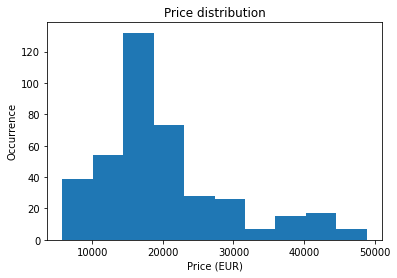

In [315]:
plt.hist(df.Price)
plt.title('Price distribution')
plt.xlabel('Price (EUR)')
plt.ylabel('Occurrence')
plt.show()

Looking at the histogram the Prices data look good. The minimum and maximum values make sense. The histogram is right skewed which is in line with the expectations: the more expensive cars are the (almost) new ones, which can be found on this website but the site's focus is on the used cars. Also, the Hungarian second hand car market relies heavily on import cars, which are usually 3+ years old.

Let's check the distribution of the Production years, also with a histogram.

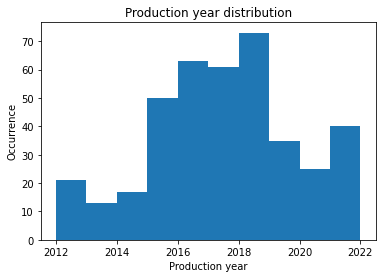

In [316]:
plt.hist(df.Year)
plt.title('Production year distribution')
plt.xlabel('Production year')
plt.ylabel('Occurrence')
plt.show()

Production year data seems good: there are no outliers or missing data. Owners usually keep their new vehicles for the first 3 years, so the drop in the number of ads between 2018 and 2022 looks normal.

Next, check the data in the Fuel type colum. Converting the texts to English makes them easier to understand for Non-Hungarians.

In [317]:
df.Fuel_type.unique()

array(['Dízel', 'Benzin', 'Hibrid (Benzin)', 'Hibrid'], dtype=object)

This car type has only one type of Hybrid engine (plub-in hybrid), so 'Hibrid (Benzin)' and 'Hibrid' categories can be merged.

In [318]:
df.Fuel_type = df.Fuel_type.replace(['Dízel'], 'Diesel')
df.Fuel_type = df.Fuel_type.replace(['Benzin'], 'Petrol')
df.Fuel_type = df.Fuel_type.replace(['Hibrid (Benzin)'], 'Hybrid')
df.Fuel_type = df.Fuel_type.replace(['Hibrid'], 'Hybrid')

In [319]:
ratio = df.groupby('Fuel_type').count().reset_index()
ratio['Ratio'] = round((ratio.Price / sum(ratio.Price)) * 100, 0)
ratio = ratio.rename(columns={'Price' : 'Number of items'})
ratio_table = ratio[['Fuel_type', 'Number of items', 'Ratio']]
ratio_table.style

,Fuel_type,Number of items,Ratio
0,Diesel,332,83.000000
1,Hybrid,25,6.000000
2,Petrol,41,10.000000


The dataset contains almost 400 lines of data, but only 10% of it is on Petrol cars and only 6% is on Hybrid cars. A note for the later analysis: the low amount of Petrol and Hybrid data brings uncertainty regarding results based on Fuel type.

The last data validation step is on column Mileage. The below histogram doesn't show any suspicious value, so this column is left unchanged.

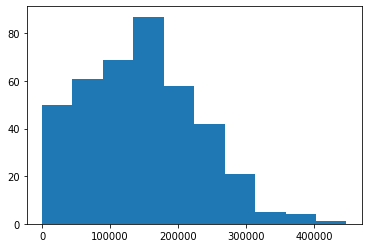

In [320]:
plt.hist(df['Mileage(KM)'])
plt.show()

People tend to use brackets for mileage data, for example the car is between 150k and 160k kilometers. Let's add a new column to the dataset, brackets of 10k kilometers.

In [321]:
df['Mileage_bracket(KM)'] = df['Mileage(KM)'] // 10000 * 10000

# Data visualization

The data is cleared and validated, so it can be visualized. First, check the prices per year and fuel type.

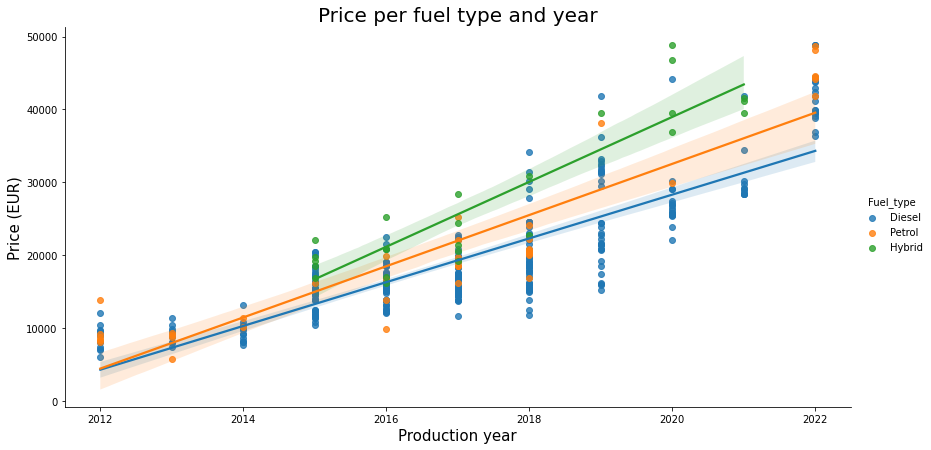

In [322]:
sns.lmplot(x = 'Year', y = 'Price', hue = 'Fuel_type', data = df, height=6, aspect=2)
plt.title('Price per fuel type and year', fontsize=20)
plt.xlabel('Production year', fontsize = 15)
plt.ylabel('Price (EUR)', fontsize = 15)
plt.show()

Based on this figure, Hybrid cars are the most expensive, and Diesel cars are the cheapest. Although it is in line with the expectations, it's worth mentioning that the low amount of data on Hybrid and Petrol cars brings uncertainty in these results. It's also interesting to see that this price difference is increasing in the case of younger cars. The below pivot table shows the price difference between the average price of Diesel cars and the average price of Hybrid and Petrol cars by year.

In [323]:
df_group = df.groupby(['Year', 'Fuel_type']).mean().reset_index()


In [324]:
pivot = df_group.pivot(index='Year', columns='Fuel_type', values='Price')
pivot['Hybrid to Diesel'] = round((pivot['Hybrid'] - pivot['Diesel']) / pivot['Diesel'] * 100, 1)
pivot['Petrol to Diesel'] = round((pivot['Petrol'] - pivot['Diesel']) / pivot['Diesel'] * 100, 1)
pivot.style

Fuel_type,Diesel,Hybrid,Petrol,Hybrid to Diesel,Petrol to Diesel
Year,,,,,
2012,8804.000000,nan,9483.666667,nan,7.700000
2013,9225.777778,nan,8243.000000,nan,-10.700000
2014,9632.066667,nan,10795.500000,nan,12.100000
2015,15052.568182,19320.400000,16277.000000,28.400000,8.100000
2016,16135.000000,20078.400000,15133.750000,24.400000,-6.200000
2017,17240.102041,22809.200000,19946.142857,32.300000,15.700000
2018,19760.451613,26837.000000,20679.333333,35.800000,4.700000
2019,25290.090909,39535.000000,38116.000000,56.300000,50.700000
2020,27247.550000,43028.500000,29974.000000,57.900000,10.000000


The average price of Hybrid cars is 28% higher than the average price of Diesel cars in the case of 7 years old cars (2015). This difference is 35.8% at 2018 and 58% at 2020. It is surprising because most of the people think that having a Diesel car gets costly with time due to the expensive parts of modern Diesel engines. Maybe they think that Hybrid cars are getting even more expensive to maintain? Again, solid conclusions can't be formed due to the low amount of data.

The below boxplot shows the prices without considering other specs (engine, miles, etc). An interesting pattern is that lowest and median prices are quite close to each other for cars which were made between 2015 and 2018. It is worth checking if it's only due to other specs, or maybe it's better to look for a car from 2018 than from earlier because we get younger car for almost the same money.

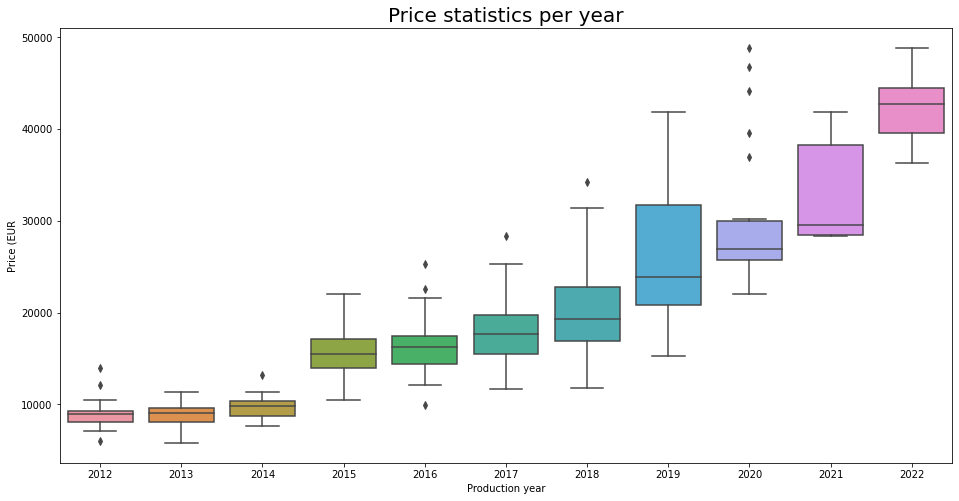

In [325]:
plt.figure(figsize=(16,8))
plt.title('Price statistics per year', fontsize=20)
sns.boxplot(data=df, x=df.Year, y=df.Price).set(xlabel = 'Production year', ylabel = 'Price (EUR')
plt.show()


Next, check the prices depending on mileage. Cars with 0 or low mileage are between 35k and 50k EUR. After the first 50k mileage, prices are between 20k and 35k EUR. It's interesting to see that the prices reach a 'threshold' of 8K at around 130k kilometres: from this point on, the price range narrows with the mileage, but the lowest price remains around 8K.

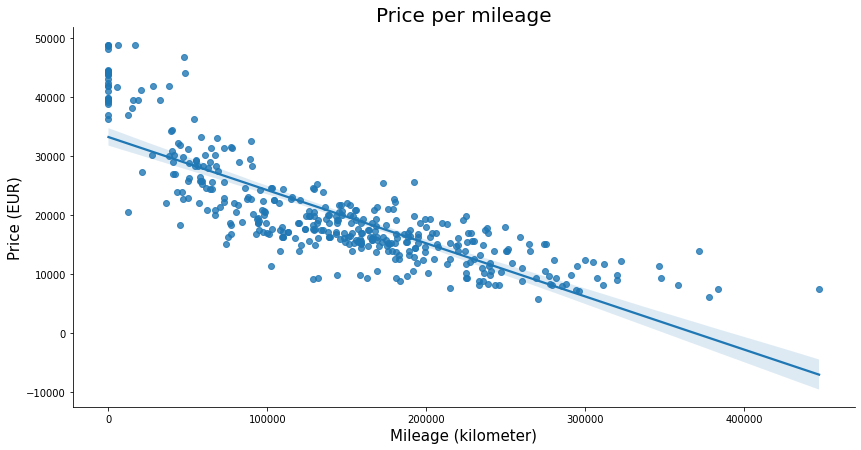

In [326]:
sns.lmplot(x = 'Mileage(KM)', y = 'Price', data = df, height=6, aspect=2)
plt.title('Price per mileage', fontsize=20)
plt.xlabel('Mileage (kilometer)', fontsize = 15)
plt.ylabel('Price (EUR)', fontsize = 15)
plt.show()

This car type has different equipment levels which are usually written in the add text. Before 2018 - 2019, the leves were: Trendline, Comfortline, Highline. After 2018 - 2019, there were only 2 levels: Business and Elegance. To make the visualization better, the new Elegance and Business levels can be merged into the previous Highline and Comfortline levels.

In [327]:
def line(row):
    if 'Trendline' in row['Description']:
        return 'Trendline'
    elif 'Highline' in row['Description'] or 'Elegance' in row['Description']:
        return 'Highline'
    elif 'Comfortline' in row['Description'] or 'Business' in row['Description']:
        return 'Comfortline'
    else:
        return 'Unknown'

df['Level'] = df.apply (lambda row: line(row), axis=1)


In [328]:
df.groupby('Level').count()

,Price,Year,Power(HP),Mileage(KM),Description,Link,Fuel_type,Mileage_bracket(KM)
Level,,,,,,,,
Comfortline,175,175,175,175,175,175,175,175
Highline,172,172,172,172,172,172,172,172
Trendline,5,5,5,5,5,5,5,5
Unknown,46,46,46,46,46,46,46,46


There are 5 Trendline, 175 Comfortline, 172 Highline and 46 Unknown data. For the following (price per level) visualizations, the Unknown data are filtered out from the dataset. Also, the 5 Trendline data would distort the plots without adding significant value, so they are excluded as well.

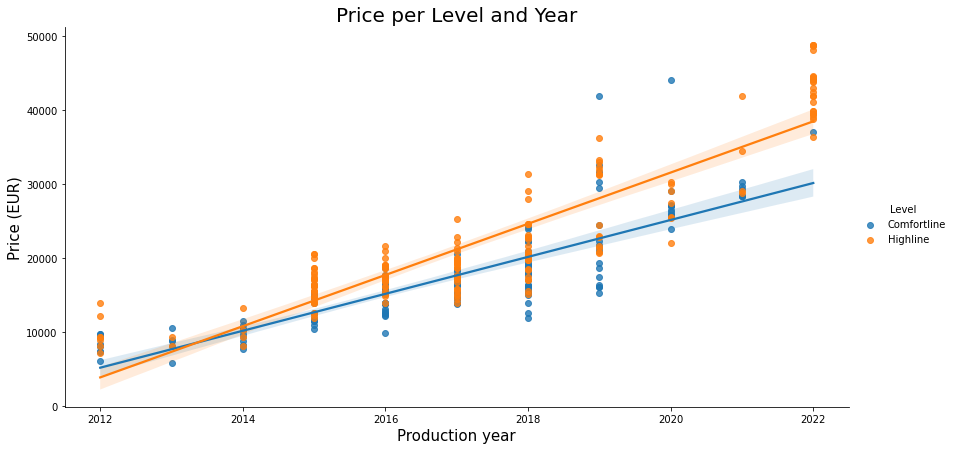

In [329]:
df_level_filtered = df[(df.Level == 'Comfortline') | (df.Level == 'Highline')]
sns.lmplot(x = 'Year', y = 'Price', hue = 'Level', data = df_level_filtered, height=6, aspect=2)
plt.title('Price per Level and Year', fontsize=20)
plt.xlabel('Production year', fontsize = 15)
plt.ylabel('Price (EUR)', fontsize = 15)
plt.show()

In [330]:
df_level_pivot = df_level_filtered.groupby(['Year', 'Level']).mean().reset_index()

In [331]:
pivot = df_level_pivot.pivot(index='Year', columns='Level', values='Price')
pivot['High to Comfort'] = round((pivot['Highline'] - pivot['Comfortline']) / pivot['Comfortline'] * 100, 1)
pivot.style

Level,Comfortline,Highline,High to Comfort
Year,,,
2012,8415.818182,9819.571429,16.700000
2013,8386.000000,8696.500000,3.700000
2014,9611.833333,10212.250000,6.200000
2015,13004.714286,16163.266667,24.300000
2016,15089.969697,17513.869565,16.100000
2017,16277.833333,18510.413793,13.700000
2018,17939.916667,21430.962963,19.500000
2019,23259.470588,27682.133333,19.000000
2020,27516.571429,27099.000000,-1.500000


Highlines are more expensive than Comfortlines, but - based on the average prices - this difference changes over the years, and it is usually between 10 and 20%.

The below boxplot compares the price statistics of the 2 Level per year. The interquartile ranges are clearly different between 2015 and 2018, but they overlap in 2019, 2020 and 2022.

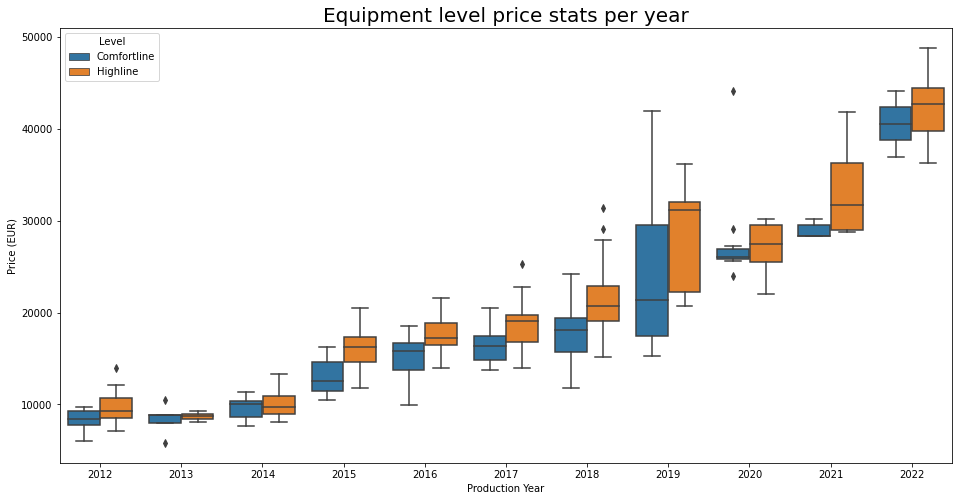

In [332]:
plt.figure(figsize=(16,8))
plt.title('Equipment level price stats per year', fontsize = 20)
sns.boxplot(data=df_level_filtered, x=df_level_filtered.Year, y=df_level_filtered.Price, hue='Level').set(xlabel = 'Production Year', ylabel = 'Price (EUR)')
plt.show()


Let's try to find a reasonable selling price of a given car (from seller perspective). The setup to check is:
- Production year = 2016
- Power = 150 HP
- Fuel type = Diesel
- Mileage bracket = 170k kilometers
- Level = Comfortline

In [333]:
df_test = df[(df.Level == 'Comfortline') & (df.Year == 2016) & (df['Power(HP)'] == 150) & (df.Fuel_type == 'Diesel')]
df_test.groupby('Mileage_bracket(KM)').count().reset_index()

,Mileage_bracket(KM),Price,Year,Power(HP),Mileage(KM),Description,Link,Fuel_type,Level
0,70000,1,1,1,1,1,1,1,1
1,90000,1,1,1,1,1,1,1,1
2,100000,3,3,3,3,3,3,3,3
3,110000,5,5,5,5,5,5,5,5
4,120000,1,1,1,1,1,1,1,1
5,130000,3,3,3,3,3,3,3,3
6,150000,1,1,1,1,1,1,1,1
7,160000,1,1,1,1,1,1,1,1
8,170000,1,1,1,1,1,1,1,1
9,180000,1,1,1,1,1,1,1,1


There is only 1 data for this given setup. The mileage brackets above and below contain very few data too, so it's better to widen the scope regarding the production year and the mileages:
- Production year: 2015 - 2017
- Mileage bracket: 160k - 180k

In [334]:
df_test = df[(df.Level == 'Comfortline') & (df['Power(HP)'] == 150) & (df.Fuel_type == 'Diesel')]
df_test = df_test[(df_test.Year == 2015) | (df_test.Year == 2016) | (df_test.Year == 2017)]
df_test = df_test[(df_test['Mileage_bracket(KM)'] == 160000) | (df_test['Mileage_bracket(KM)'] == 170000) | (df_test['Mileage_bracket(KM)'] == 180000)]

df_test.count()

Price                  8
Year                   8
Power(HP)              8
Mileage(KM)            8
Description            8
Link                   8
Fuel_type              8
Mileage_bracket(KM)    8
Level                  8
dtype: int64

The new filter leaves 8 lines in the dataset. It is still very low amount of data, but the further widening of the scope would distort our results.

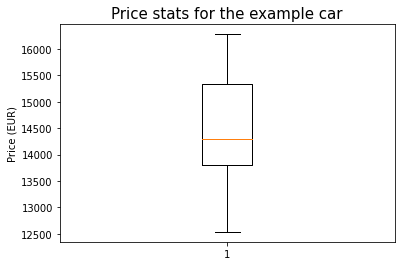

In [335]:
plt.boxplot(df_test.Price)
plt.title('Price stats for the example car', fontsize=15)
plt.ylabel('Price (EUR)')
plt.show()

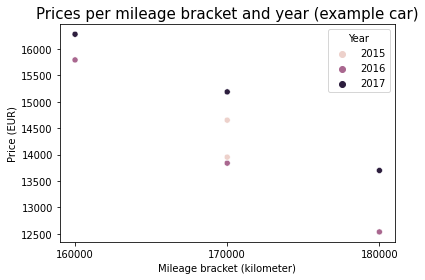

In [336]:
sns.scatterplot(x=df_test['Mileage_bracket(KM)'], y=df_test.Price, hue=df_test.Year)
plt.title('Prices per mileage bracket and year (example car)', fontsize=15)
plt.xlabel('Mileage bracket (kilometer)')
plt.ylabel('Price (EUR)')
plt.xticks([160000, 170000, 180000])
plt.show()

In [337]:
print(df_test.Price.median())
print(df_test.Price.quantile(0.75))

14301.0
15337.25


The low amount of data makes it difficult to draw conclusions. Based on the above Boxplot, half of the cars with such setup are sold above 14301 EUR, and 25% is sold above 15337 EUR. But, considering merley the mileage bracket of 170k kilometers, only a car from 2017 is above 15k EUR. A selling price depends on many specific factors. This dataset supports a possible selling price of around 14500 EUR.

Let's try to check how much do the years and the mileages cost. The setup is:
- Level: Comfortline
- Power: 150 HP
- Fuel type: Diesel

To check the cost of Mileages, fix the year on 2016.

In [338]:
df_test2 = df[(df.Level == 'Comfortline') & (df['Power(HP)'] == 150) & (df.Fuel_type == 'Diesel')]

In [339]:
df_test_mileage = df_test2[df_test2.Year == 2016]
df_test_mileage = df_test_mileage[(df_test_mileage['Mileage_bracket(KM)'] > 130000) & (df_test_mileage['Mileage_bracket(KM)'] < 200000)]

In [340]:
df_test_mileage.groupby('Mileage_bracket(KM)').count().reset_index()

,Mileage_bracket(KM),Price,Year,Power(HP),Mileage(KM),Description,Link,Fuel_type,Level
0,150000,1,1,1,1,1,1,1,1
1,160000,1,1,1,1,1,1,1,1
2,170000,1,1,1,1,1,1,1,1
3,180000,1,1,1,1,1,1,1,1
4,190000,2,2,2,2,2,2,2,2


In [341]:
df_test_mileage = df_test_mileage.groupby('Mileage_bracket(KM)').mean().reset_index()
df_test_mileage

,Mileage_bracket(KM),Price,Year,Power(HP),Mileage(KM)
0,150000,15812.0,2016.0,150.0,155659.0
1,160000,15791.0,2016.0,150.0,165529.0
2,170000,13837.0,2016.0,150.0,176000.0
3,180000,12535.0,2016.0,150.0,182500.0
4,190000,12546.0,2016.0,150.0,195000.0


In [342]:
(df_test_mileage.Price[0] - df_test_mileage.Price[4]) / 4

816.5

This dataset shows an average cost of 816 EUR / 10000 kilometers between 130k and 200k mileage, for the cars which were produced in 2016.

Increase the years to 2015 - 2017 to have more data:

In [343]:
df_test_mileage_inc = df_test2[(df_test2.Year == 2015) | (df_test2.Year == 2016) | (df_test2.Year == 2017)]

In [344]:
df_test_mileage_inc = df_test_mileage_inc[(df_test_mileage_inc['Mileage_bracket(KM)'] > 130000) & (df_test_mileage_inc['Mileage_bracket(KM)'] < 200000)]

In [345]:
df_test_mileage_inc.groupby('Mileage_bracket(KM)').count().reset_index()

,Mileage_bracket(KM),Price,Year,Power(HP),Mileage(KM),Description,Link,Fuel_type,Level
0,140000,2,2,2,2,2,2,2,2
1,150000,6,6,6,6,6,6,6,6
2,160000,2,2,2,2,2,2,2,2
3,170000,4,4,4,4,4,4,4,4
4,180000,2,2,2,2,2,2,2,2
5,190000,4,4,4,4,4,4,4,4


In [346]:
df_test_mileage_inc = df_test_mileage_inc.groupby('Mileage_bracket(KM)').mean().reset_index()
df_test_mileage_inc

,Mileage_bracket(KM),Price,Year,Power(HP),Mileage(KM)
0,140000,16837.000000,2017.000000,150.0,145693.50
1,150000,15704.666667,2016.833333,150.0,156210.00
2,160000,16034.000000,2016.500000,150.0,165806.50
3,170000,14406.250000,2015.750000,150.0,176113.75
4,180000,13116.500000,2016.500000,150.0,181750.00
5,190000,13533.500000,2016.500000,150.0,195529.50


In [347]:
(df_test_mileage_inc.Price[0] - df_test_mileage_inc.Price[5]) / 5

660.7

The dataset shows an average cost of 660 EUR / 10000 kilometers between 130k and 200k mileage, for the cars which were produced in 2015 - 2017.

To check how much a year cost, fix the mileages between 160k and 180k:

In [348]:
df_test_year = df_test2[(df_test2['Mileage_bracket(KM)'] > 160000) & (df_test2['Mileage_bracket(KM)'] < 180000)]

In [349]:
df_test_year = df_test_year.groupby('Year').mean().reset_index()
df_test_year

,Year,Price,Power(HP),Mileage(KM),Mileage_bracket(KM)
0,2015,14301.000000,150.0,174250.000000,170000.0
1,2016,13837.000000,150.0,176000.000000,170000.0
2,2017,15186.000000,150.0,179955.000000,170000.0
3,2018,15386.333333,150.0,174447.333333,170000.0


In [351]:
(df_test_year.Price[3] - df_test_year.Price[0]) / 3

361.777777777778

The dataset shows an average cost of 362 EUR / year for the given setup.